### Basic Metadata

In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS custom_information_schema;


In [0]:
%sql
CREATE OR REPLACE TABLE custom_information_schema.columns_info (
    table_catalog STRING,
    table_schema STRING,
    table_name STRING,
    column_name STRING,
    data_type STRING
);

**Storing basic metadata for all the tables created for the ETL pipeline**

In [0]:
import logging
from pyspark.sql import SparkSession

# Configure structured logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(module)s - %(message)s",
    handlers=[logging.StreamHandler()]
)

# Initialize Spark session
spark = SparkSession.builder.appName("MetadataExtraction").getOrCreate()

try:
    # Define catalog name
    catalog = "ddca_final_project_databricks_workspace"
    logging.info(f"Using catalog: {catalog}")

    # Set the active catalog
    spark.sql(f"USE CATALOG {catalog}")
    logging.info(f"Successfully set active catalog: {catalog}")

    # Fetch all schemas (databases) in the catalog
    try:
        df = spark.sql(f"SHOW DATABASES IN {catalog}").collect()
        schema_list = [row.databaseName for row in df]
        logging.info(f"Fetched {len(schema_list)} schemas from catalog: {catalog}")
    except Exception as e:
        logging.error(f"Failed to fetch schemas from catalog: {catalog}. Error: {str(e)}")
        raise RuntimeError(f"Error fetching schemas: {str(e)}") from e

    # Loop through each schema
    for schema in schema_list:
        try:
            # Skip the "information_schema"
            if schema == "information_schema":
                logging.info(f"Skipping reserved schema: {schema}")
                continue

            logging.info(f"Processing schema: {schema}")
            spark.sql(f"USE {catalog}.{schema}")
            logging.info(f"Successfully set active schema: {schema}")

            # Fetch all tables in the schema
            df = spark.sql(f"SHOW TABLES IN {catalog}.{schema}").collect()
            table_list = [row.tableName for row in df if not row.isTemporary]

            if not table_list:
                logging.info(f"No tables found in schema: {schema}")
                continue

            logging.info(f"Fetched {len(table_list)} tables in schema: {schema}")

            # Loop through each table
            for table_name in table_list:
                try:
                    # Skip temporary or internal tables
                    if table_name.startswith("_sqldf"):
                        logging.info(f"Skipping temporary/internal table: {table_name}")
                        continue

                    # Verify table existence
                    check_table = spark.sql(f"SHOW TABLES IN {catalog}.{schema}").filter(f"tableName = '{table_name}'").collect()
                    if not check_table:
                        logging.warning(f"Table not found: {table_name}")
                        continue

                    logging.info(f"Processing table: {table_name}")

                    # Fetch table metadata using DESCRIBE TABLE EXTENDED
                    table_info = spark.sql(f"DESCRIBE TABLE EXTENDED {catalog}.{schema}.{table_name}").collect()
                    logging.info(f"Successfully fetched metadata for table: {table_name}")

                    # Store table-level metadata in a dictionary
                    table_info_dict = {}
                    first_row_keys = table_info[0].asDict().keys()

                    for row in table_info:
                        row_dict = row.asDict()
                        for key, value in row_dict.items():
                            if key and value:
                                table_info_dict[key] = value

                    # Fetch column-level metadata
                    table_column_info = spark.sql(f"DESCRIBE TABLE {catalog}.{schema}.{table_name}").collect()
                    logging.info(f"Successfully fetched column-level metadata for table: {table_name}")

                    # Insert column-level metadata into custom information schema table
                    for row in table_column_info:
                        column_name = row['col_name']
                        data_type = row['data_type']

                        insert_query = f"""
                            INSERT INTO {catalog}.custom_information_schema.columns_info 
                            VALUES ('{catalog}', 
                                    '{schema}', 
                                    '{table_name}',
                                    '{column_name}', 
                                    '{data_type}')
                        """
                        try:
                            spark.sql(insert_query)
                            logging.info(f"Inserted metadata for column: {column_name} in table: {table_name}")
                        except Exception as e:
                            logging.error(f"Error inserting metadata for column: {column_name} in table: {table_name}. Error: {str(e)}")
                            raise RuntimeError(f"Error during metadata insertion: {str(e)}") from e

                except Exception as e:
                    logging.error(f"Critical failure while processing table: {table_name}. Error: {str(e)}")
                    raise RuntimeError(f"Critical failure: {str(e)}") from e

        except Exception as e:
            logging.error(f"Critical failure while processing schema: {schema}. Error: {str(e)}")
            raise RuntimeError(f"Critical failure: {str(e)}") from e

    logging.info("Metadata extraction completed successfully!")

except Exception as e:
    logging.error(f"Critical failure during the metadata extraction process. Error: {str(e)}")
    raise RuntimeError(f"Critical failure: {str(e)}") from e

**Example basic metadata for tables in gold schema**

In [0]:
%sql
SELECT * FROM custom_information_schema.columns_info WHERE table_schema = 'bronze'


table_catalog,table_schema,table_name,column_name,data_type
ddca_final_project_databricks_workspace,bronze,appearance,appearance_id,string
ddca_final_project_databricks_workspace,bronze,appearance,game_id,int
ddca_final_project_databricks_workspace,bronze,appearance,player_id,int
ddca_final_project_databricks_workspace,bronze,appearance,player_club_id,int
ddca_final_project_databricks_workspace,bronze,appearance,player_current_club_id,int
ddca_final_project_databricks_workspace,bronze,appearance,date,date
ddca_final_project_databricks_workspace,bronze,appearance,player_name,string
ddca_final_project_databricks_workspace,bronze,appearance,competition_id,string
ddca_final_project_databricks_workspace,bronze,appearance,yellow_cards,int
ddca_final_project_databricks_workspace,bronze,appearance,red_cards,int


### Relationships of the original dataset
Source of the image below: https://www.kaggle.com/datasets/davidcariboo/player-scores/data


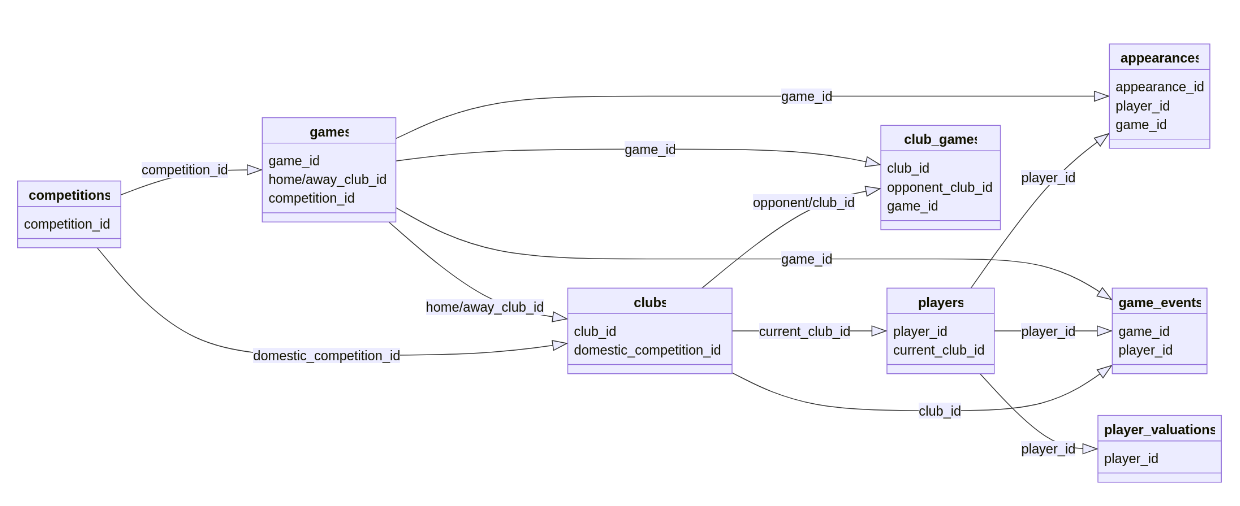

In [0]:
from IPython.display import Image

image_path = "/Workspace/Users/tesfamit03@gmail.com/images/original-dataset-connection.png"

Image(image_path)
